# CLEAN BUILD FROM SCRATCH EFFNET-UNET b7 on patches

In [1]:
CURRENT_FOLD = 1

# imports

In [2]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
from customeunet.utils import *
from customeunet.layers import *
from customeunet.efficientnet import *
from customeunet.efficientunet import *

# model

In [4]:
def AUXhead(in_channels, mid_channels, out_channels, upsample=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=upsample, mode='bilinear')
    )

In [5]:
class EfficientUnetAUX(nn.Module):
    def __init__(self, backbone, n_classes=2, concat_input=True):
        super().__init__()
        
        self.backbone = backbone
        
        self.encoder = EfficientNet.encoder(backbone, pretrained=True)
        self.model = EfficientUnet(self.encoder, out_channels=n_classes, concat_input=True)
        
        self.aux3head = AUXhead(128, 256, n_classes, 4)
        self.aux2head = AUXhead(256, 256, n_classes, 8)
        
    def forward(self, x):
        data = self.model(x)
        aux2 = self.aux2head(data['aux2'])
        aux3 = self.aux3head(data['aux3'])
        out = {
            'logits': data['x'],
            'aux2': aux2,
            'aux3': aux3,
        }
        return out

In [6]:
model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6)

In [7]:
inp = torch.randn(1, 3, 512, 512)

In [8]:
ot = model(inp)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [9]:
ot.keys()

dict_keys(['logits', 'aux2', 'aux3'])

In [10]:
ot['logits'].shape, ot['aux2'].shape, ot['aux3'].shape

(torch.Size([1, 6, 512, 512]),
 torch.Size([1, 6, 512, 512]),
 torch.Size([1, 6, 512, 512]))

# data

In [11]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

## data 512

In [12]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [13]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_data_eunet_patches/512/train/'
TRAIN_MASKS_DIR = './../data/train_data_eunet_patches/512/masks/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022
CURRENT_FOLD = 1

SPATIAL_SIZE = 512 # размер патча


In [14]:
train_df = pd.read_csv(TRAIN_CSV)

In [15]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [16]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [17]:
def make_512_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('/train/', '/masks/')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [18]:
train_df_512 = make_512_dataset(train_df)
print(train_df_512.shape)
train_df_512.head()

(2895, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
1,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
2,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
3,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4
4,4.0,10044,./../data/train_data_eunet_patches/512/train/1...,./../data/train_data_eunet_patches/512/masks/1...,prostate,0.4


In [19]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

In [20]:
train_transform= A.Compose([
    A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HueSaturationValue(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean, std=std, 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [21]:
val_transform = A.Compose([
    A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=mean, std=std, 
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [22]:
class HubmapDataset512(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])

        data.update(upd_data)
        return data

In [23]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [24]:
train_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] == CURRENT_FOLD], val_transform)

IMAGE
torch.Size([3, 512, 512])
image values:  -2.552311420440674 0.8210051655769348


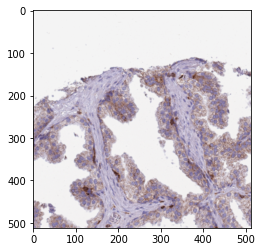

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


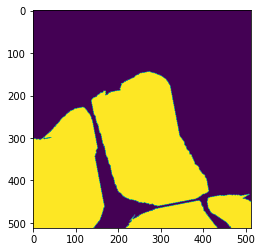

In [25]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)) * std + mean)
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [26]:
BATCH_SIZE = 6

In [27]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=12
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

IMAGE
torch.Size([3, 512, 512])
image values:  -2.1532299518585205 0.8210051655769348


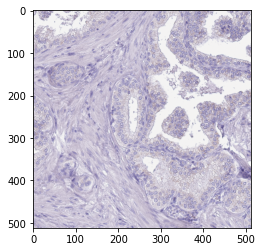

MASK
torch.Size([512, 512])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


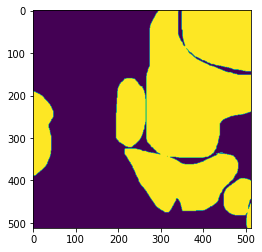

In [28]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].permute((1, 2, 0)) * std + mean)
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# Estimate weights

In [168]:
train_dataset = HubmapDataset512(train_df_512[train_df_512['fold'] != CURRENT_FOLD], val_transform)

In [169]:
pixel_counts = {key: 0 for key in range(6)}
for elem in tqdm(train_dataset):
    organ = np.uint8(elem['organ']) + 1 
#     print(organ)
#     print(elem['mask'].detach().cpu().numpy().astype(np.uint8))
    sm = elem['mask'].detach().cpu().numpy().astype(np.uint8) == organ
#     print(sm)
    pixel_counts[organ] += sm.sum()
    pixel_counts[0] += (~sm).sum()
#     print(pixel_counts)
#     _ = input()

100%|██████████| 2316/2316 [00:52<00:00, 43.77it/s]


In [170]:
total_pixel_cnt = sum(pixel_counts.values())

In [175]:
for i in range(6):
    if i == 0:
        print('Background      : {:9.6f} %'.format(pixel_counts[i] * 100 / total_pixel_cnt))
    else:
        print('{:15} : {:9.6f} %'.format(ID2ORGAN[i - 1], pixel_counts[i] * 100 / total_pixel_cnt))

Background      : 90.132840 %
kidney          :  0.847332 %
prostate        :  3.837995 %
largeintestine  :  3.391695 %
spleen          :  1.526907 %
lung            :  0.263231 %


# VALID

In [176]:
device = 'cuda:2'
DEVICE = device

In [177]:
model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6).to(device)

In [233]:
model.load_state_dict(torch.load('./checkpoint_fold_1/effunet_ep_070_dice_00000nan_loss_0.061283.pt', map_location=device))

<All keys matched successfully>

In [234]:
_ = model.eval()

In [235]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

77928738

In [236]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [237]:
def get_dice_coefficient(output, target, classes):
    output,target = output.detach().cpu(), target.detach().cpu()
#     print(target.any())
    target = (target > 0)[0]
    output = F.softmax(output, dim=1)
    output = output[0, classes[0] + 1]
    
#     plt.imshow(target)
#     plt.show()
#     plt.imshow(output)
#     plt.show()
    
    output = output > 0.5
    
    target = target.detach().cpu().numpy()
    output = output.detach().cpu().numpy()
    
#     plt.imshow(target)
#     plt.show()
#     plt.imshow(output)
#     plt.show()
    
    dice_coe = dice_coef2(target, output)
#     print('DICE ', dice_coe)
#     print(dice_coe.isnan().any())
    return dice_coe

In [238]:
dices = []
by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
for iteration, batch in tqdm(enumerate(loader_val, 1)):
    images = batch['image'].to(device, dtype=torch.float)
    masks = batch['mask'].to(device, dtype=torch.long)
    classes = batch['organ'].detach().numpy()
    
#     print(ID2ORGAN[classes[0]])

    pred = model(images)['logits']

    dice = get_dice_coefficient(pred, masks, classes)
    dices.append(dice)
    by_organ_dice[ID2ORGAN[classes[0]]].append(dice)
#     _ = input()


0it [00:00, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
579it [01:01,  9.45it/s]


In [239]:
print(np.mean(dices))
for key, value in by_organ_dice.items():
    print('{:20}: {:6.5f}'.format(key, np.mean(value)))

0.7376626004339373
kidney              : 0.84579
prostate            : 0.75260
largeintestine      : 0.85522
spleen              : 0.69704
lung                : 0.34354


# calculating dice loss for every checkpoint

In [240]:
ch_dicts = []

for fname in glob('./checkpoint_fold_1/effunet_ep_005_dice_00000nan_loss_0.467563.pt'):
    print(fname)
    model = EfficientUnetAUX(backbone='efficientnet-b7', n_classes=6).to(device)
    
    model.load_state_dict(torch.load(fname, map_location=device))
    
    _ = model.eval()
    
    dices = []
    by_organ_dice = {key:[] for key in ORGAN2ID.keys()}
    with torch.no_grad():
        for iteration, batch in tqdm(enumerate(loader_val, 1)):
            images = batch['image'].to(device, dtype=torch.float)
            masks = batch['mask'].to(device, dtype=torch.long)
            classes = batch['organ'].detach().numpy()

            pred = model(images)['logits']

            dice = get_dice_coefficient(pred, masks, classes)
            dices.append(dice)
            by_organ_dice[ID2ORGAN[classes[0]]].append(dice)
        
    new_record = dict()
    new_record['dices'] = dices
    new_record['by_organ'] = by_organ_dice
    new_record['fname'] = fname
    ch_dicts.append(new_record)
#     break

0it [00:00, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
579it [00:55, 10.40it/s]


In [241]:
ch_dicts

[{'dices': [0.0,
   0.24279912527335207,
   0.8806957354290501,
   0.0,
   0.0,
   0.845655322230268,
   0.7633191316697099,
   0.6233787488236979,
   0.17372760424924688,
   0.0,
   1,
   1,
   1,
   0.0,
   0.0,
   1,
   1,
   0.0,
   1,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1,
   0.8523684023078567,
   0.6601082144613871,
   0.8473211165785449,
   0.824483518020065,
   0.8633366633366634,
   0.8955308852832337,
   0.0,
   1,
   0.0,
   1,
   0.0,
   1,
   0.0,
   1,
   1,
   0.0,
   1,
   1,
   0.0,
   0.0,
   1,
   0.0,
   1,
   1,
   0.6272729969446175,
   0.5926996674315405,
   0.0,
   0.0,
   0.4246418498142925,
   0.742930870241526,
   0.7397466028167023,
   0.4660692791226428,
   0.8675346425002026,
   0.0,
   1,
   0.0,
   1,
   1,
   1,
   0.0,
   1,
   0.0,
   0.0,
   0.0,
   0.0,
   1,
   0.0,
   1,
   0.0,
   1,
   1,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1,
   1,
   1,
   0.8598112465591821,
   0.9570633156539536,
   0.7361615574604097,
   0.866

# losses

In [196]:
# !pip install -U segmentation-models-pytorch

In [197]:
import segmentation_models_pytorch

In [199]:
criterion2 = segmentation_models_pytorch.losses.TverskyLoss(
    mode='multiclass', classes=None, log_loss=False, 
    from_logits=True, smooth=0.0, ignore_index=None, 
    eps=1e-07, alpha=0.5, beta=0.5, gamma=1.0
)

In [ ]:
y_pred = torch.tensor([[], []])

In [ ]:
criterion2()